In [1]:
import torch#
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys
import time
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

import os
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

c:\Users\Scent\anaconda3\envs\CENT000\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 指定されたプロシージャが見つかりません。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
print(f'Using device: {device}')


GPU name: NVIDIA GeForce GTX 1660
Using device: cuda


In [3]:
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)

# CSVファイルの読み込み
file_path =os.path.join(onedrive_path,'CODES','samples','engine_data.csv')
data = pd.read_csv(file_path)

# データの前処理
data = data.dropna()  # 欠損値を削除

# 特徴量とターゲットに分ける
# 'Engine Condition' をターゲット変数として仮定
X = data.drop(columns=['Engine Condition'])
y_origin = data['Engine Condition']

# 特徴量を標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)#平均と標準偏差を使ってデータをスケーリング



In [4]:
def get_new_dataloader(X_scaled, y_origin, test_size=0.2, batch_size=32):
    # ランダムに分割（シャッフル付き）
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_origin, test_size=test_size, shuffle=True
    )

    # クラス数カウント
    num_pos = (y_train == 1).sum()
    num_neg = (y_train == 0).sum()
    #print('abnormal', num_pos)
    #print('normal', num_neg)

    # Tensor変換
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

    # DataLoader 作成
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, num_pos, num_neg

In [5]:
#EncoderLI
class Encoder(nn.Module):
    def __init__(self,input_dim, leverage):
        super(Encoder, self).__init__()
        self.leverage = leverage
        output_dim = int(input_dim // leverage)
        self.B = nn.Parameter(torch.randn(output_dim, input_dim) * (input_dim))#.to(device)
        self.B.requires_grad = False

    
    def forward(self, x):
        x = x.T
        x = torch.matmul(self.B,x)
        x = x.T
        return x

In [6]:

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        mid1 = max(4, input_dim * 3)  # 入力の3倍。ただし最小4にする
        self.fc1 = nn.Linear(input_dim,mid1)
        self.fc2 = nn.Linear(mid1, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [7]:
class EncoderClassifier(nn.Module):
    def __init__(self,input_dim, leverage):
        super(EncoderClassifier, self).__init__()
        potential_dim = int(input_dim//leverage)
        self.encoder = Encoder(input_dim,leverage,) 
        self.classifier =  MLP(potential_dim)
        
    def forward(self, x):
        x = self.encoder(x) 
        x = self.classifier(x)
        return x

1:1 1th Epoch: 29/30

IN [-1.0098463   0.21220034 -0.7603883  -0.6978614  -0.21864873  0.7479933 ]
OUT tensor([  4.7203, -13.1563,  -8.2527,  19.7743,  -2.0590,   4.7970],
       device='cuda:0')


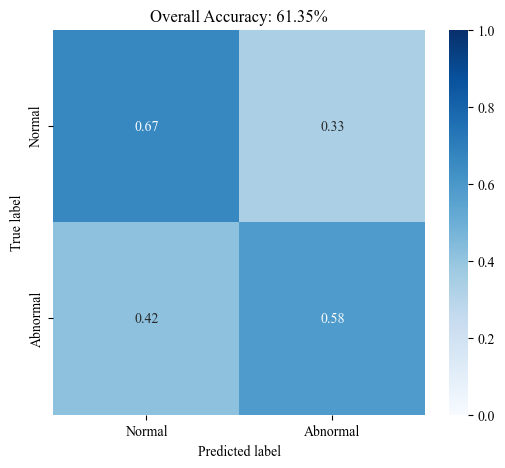

1:1 2th Epoch: 29/30

IN [-0.5427388  -1.1049162   0.47912836 -0.918989    0.03100135  0.65111786]
OUT tensor([11.9470, -4.5999,  0.9517, -3.8383, -5.8172, -5.7080], device='cuda:0')


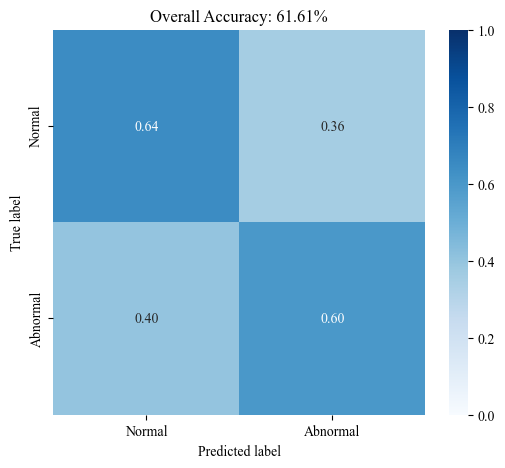

1:1 3th Epoch: 29/30

IN [-1.3835323   0.777161   -0.53397447  0.7266286  -0.3004486   0.45911157]
OUT tensor([  2.4609,   3.5487, -11.9906, -20.6127,   0.5784, -11.5839],
       device='cuda:0')


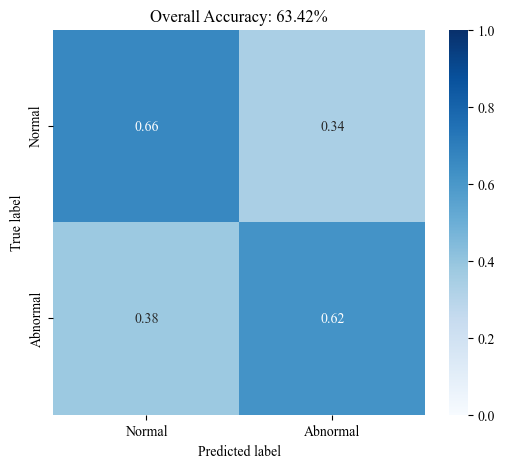

1:1 4th Epoch: 29/30

IN [ 0.05142195 -1.0025985  -0.8548642  -0.5815593   2.0923214   1.7141844 ]
OUT tensor([-19.3425, -11.3056, -18.9033,  16.2053,  -9.6556,  -1.9240],
       device='cuda:0')


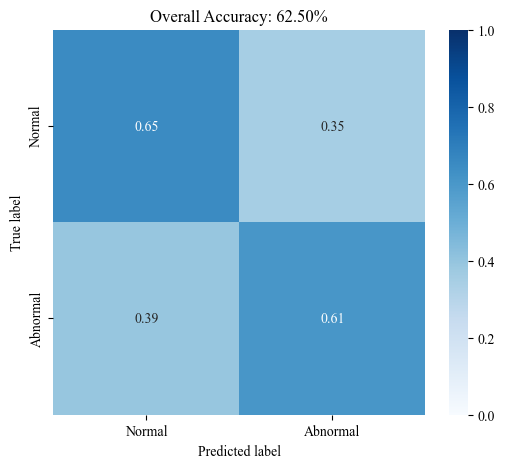

1:1 5th Epoch: 29/30

IN [-1.1219522   1.1583165  -0.47135213 -0.01659858 -0.5872495   0.7969943 ]
OUT tensor([  4.3542,  -5.0932,   3.9716, -17.2673,  12.1573, -13.2004],
       device='cuda:0')


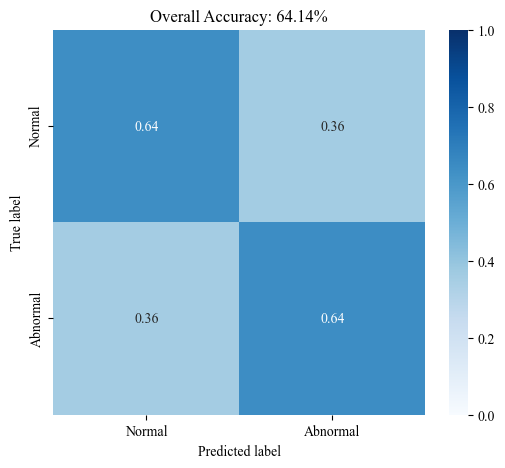

           Average  Best ID       Best  Worst ID      Worst
0   ACC  62.605580        5  64.141285         1  61.351421
1  LOSS   0.609571        5   0.602764         2   0.617964


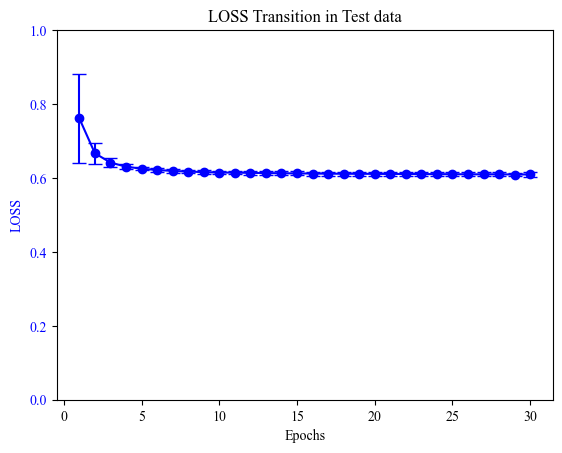

1:2 1th Epoch: 29/30

IN [-0.98742515 -0.95276374  0.09096454  0.04609292 -0.21146645  1.4266094 ]
OUT tensor([11.5155, 10.5739,  3.1087], device='cuda:0')


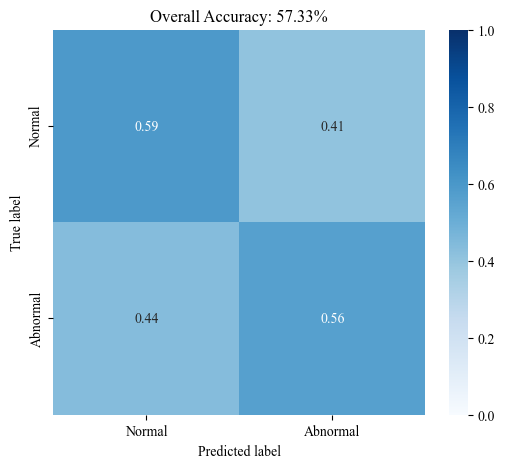

1:2 2th Epoch: 29/30

IN [-0.17278966 -0.3241175   0.01104317  0.19929539 -0.41494238 -0.24173178]
OUT tensor([-0.4002,  0.8304, -4.2894], device='cuda:0')


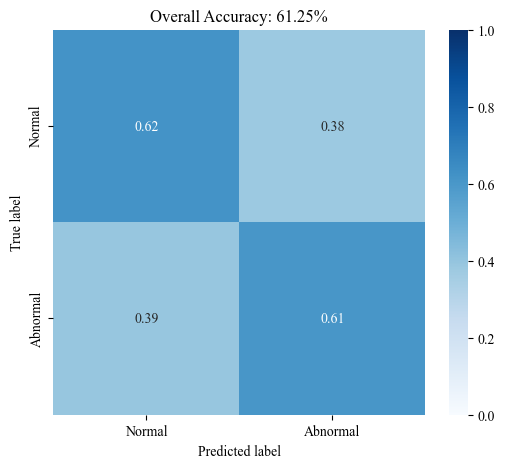

1:2 3th Epoch: 29/30

IN [ 0.5260032  -0.56071866 -1.7209915  -0.29069862 -0.38504913 -1.1286095 ]
OUT tensor([-7.7558,  6.7623, -8.5583], device='cuda:0')


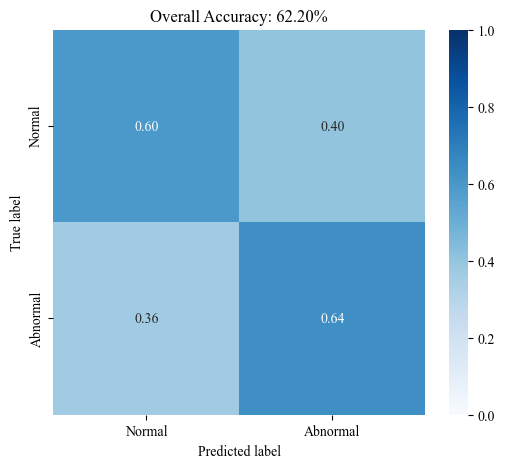

1:2 4th Epoch: 29/30

IN [-0.725845    0.8318129  -0.3933228  -0.72297287 -1.1906945  -1.1338083 ]
OUT tensor([ 3.3505, -3.4419, 12.6540], device='cuda:0')


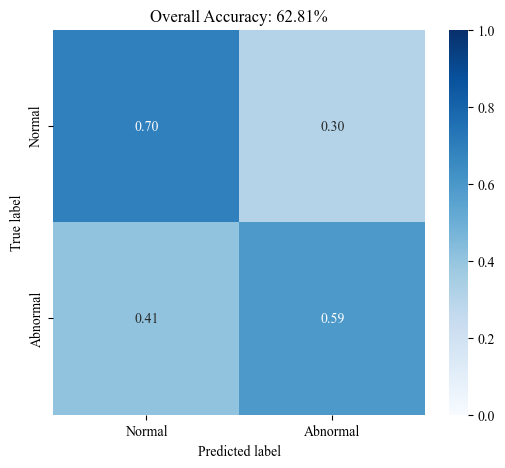

1:2 5th Epoch: 29/30

IN [-0.55768627  1.3685161   0.0577683   2.0454993   1.6771989   1.0212803 ]
OUT tensor([21.6458, 38.5093, -4.0680], device='cuda:0')


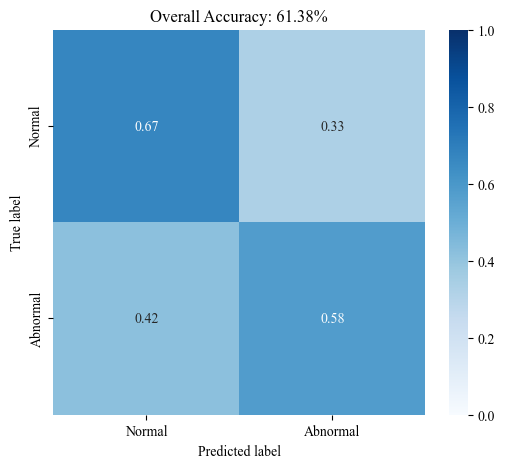

           Average  Best ID       Best  Worst ID      Worst
0   ACC  60.993089        4  62.810340         1  57.332992
1  LOSS   0.621296        4   0.599275         1   0.637711


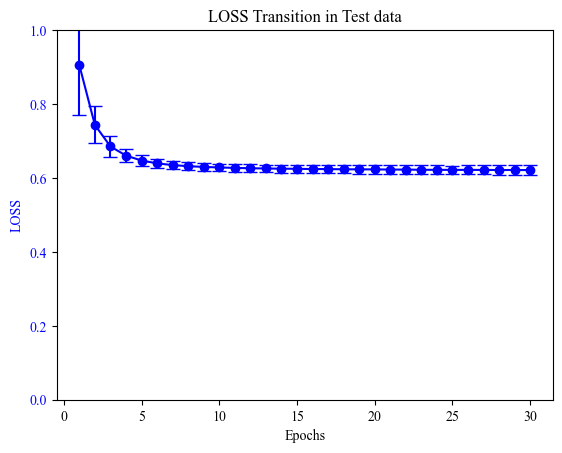

1:3 1th Epoch: 29/30

IN [ 0.86605746 -0.17212844 -1.3385097   0.01086894 -0.1889191   0.58171904]
OUT tensor([12.6815, -2.3603], device='cuda:0')


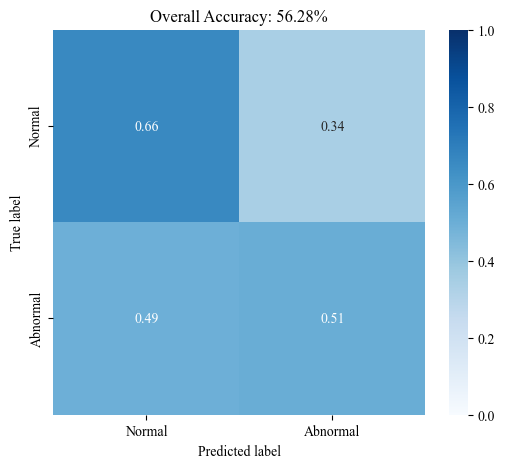

1:3 2th Epoch: 29/30

IN [-1.0247937   1.1305785   0.4735337   0.27868935 -1.2445899  -0.94525105]
OUT tensor([-2.5662, 15.1433], device='cuda:0')


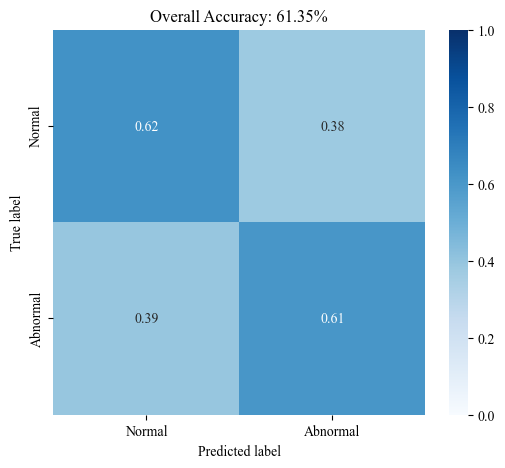

1:3 3th Epoch: 29/30

IN [-0.12047362 -0.49394277  1.006561   -0.06895943  0.23298977  0.18548642]
OUT tensor([-5.9369, -0.0966], device='cuda:0')


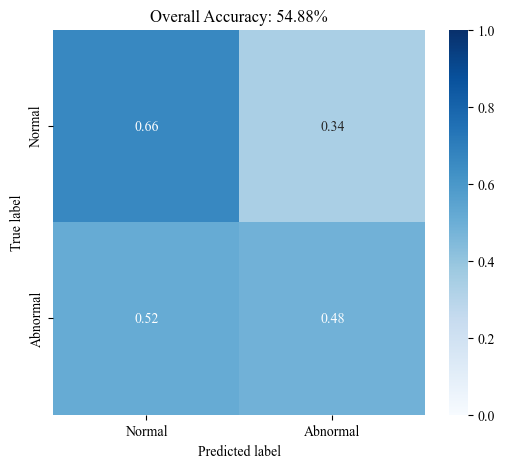

1:3 4th Epoch: 29/30

IN [ 0.3653182   0.8357511   0.5806592   1.8933642  -0.4957752  -0.49720907]
OUT tensor([-1.6140, 15.5559], device='cuda:0')


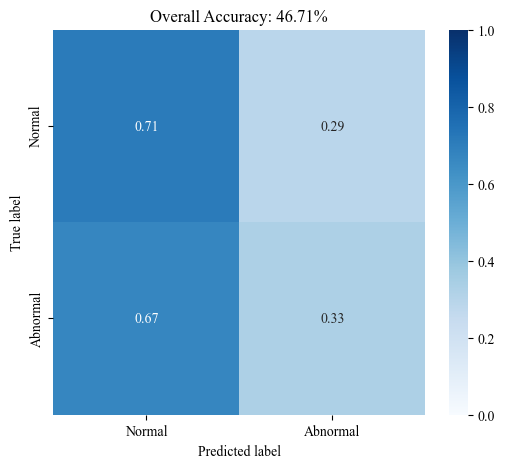

1:3 5th Epoch: 29/30

IN [-0.92763543  1.6231115   2.1530302   0.85017586 -0.17619479 -0.6487785 ]
OUT tensor([12.0155,  3.3605], device='cuda:0')


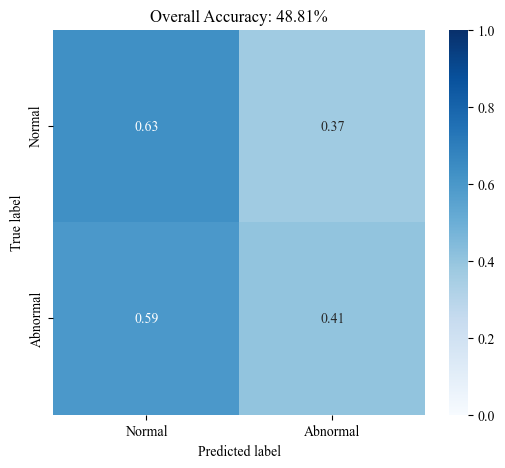

           Average  Best ID       Best  Worst ID      Worst
0   ACC  53.606348        2  61.351421         4  46.711031
1  LOSS   0.643292        2   0.631235         5   0.656818


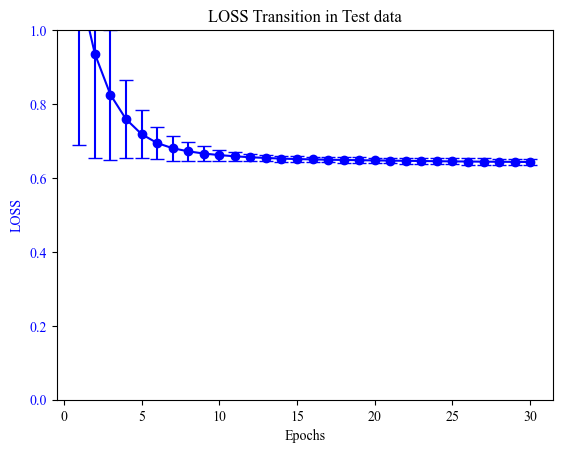

1:6 1th Epoch: 29/30

IN [-0.5427388  -0.82518995 -1.4229771  -0.6107787   0.1612457  -0.0576942 ]
OUT tensor([3.9980], device='cuda:0')


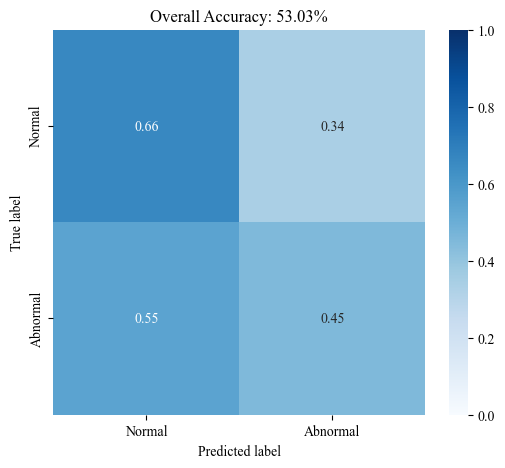

1:6 2th Epoch: 29/30

IN [ 1.6470612  1.755296  -1.508758  -1.4263849 -0.3352744  1.0987654]
OUT tensor([28.0117], device='cuda:0')


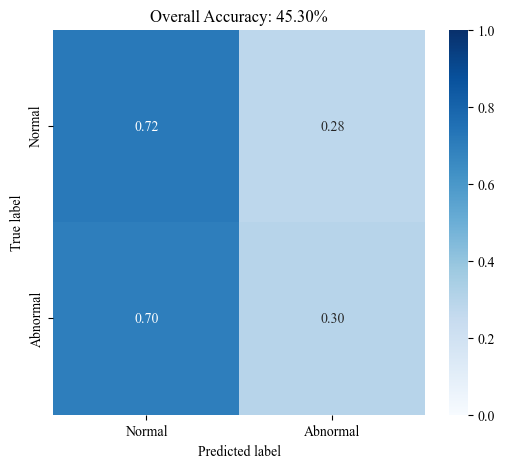

1:6 3th Epoch: 29/30

IN [-1.4358484   1.2301117  -0.31364757  0.28777733  0.04804523  1.7117237 ]
OUT tensor([-9.0728], device='cuda:0')


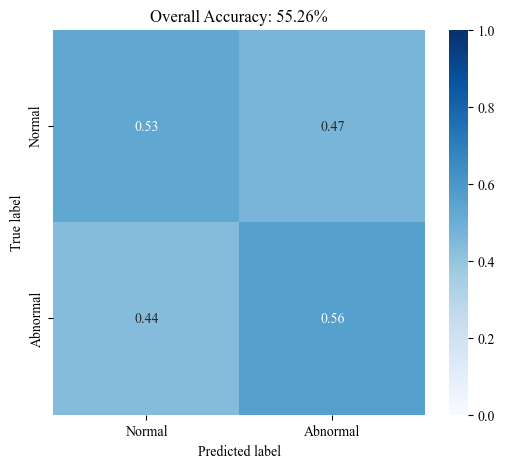

1:6 4th Epoch: 29/30

IN [ 0.6082141   0.11110075 -0.48015255  0.8925661  -0.6039004   0.45484847]
OUT tensor([7.0110], device='cuda:0')


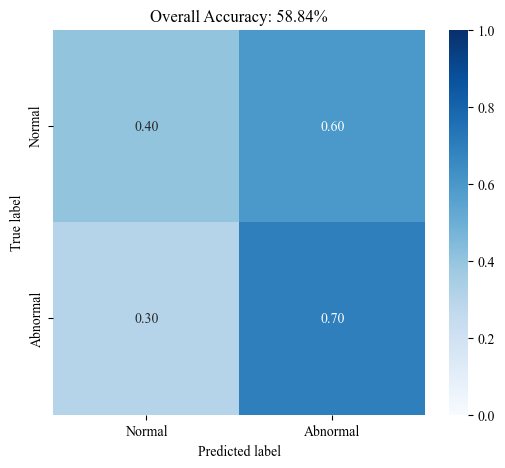

1:6 5th Epoch: 29/30

IN [-0.81926644  0.38371968 -1.2005398  -0.96387607  0.41504437 -0.21703419]
OUT tensor([5.1869], device='cuda:0')


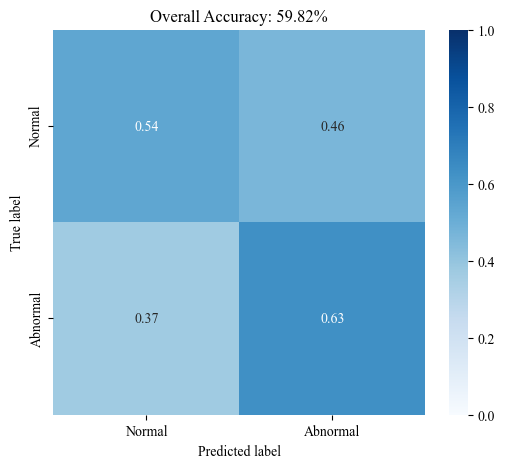

           Average  Best ID       Best  Worst ID      Worst
0   ACC  54.450985        5  59.815715         2  45.303302
1  LOSS   0.646991        5   0.629478         2   0.653852


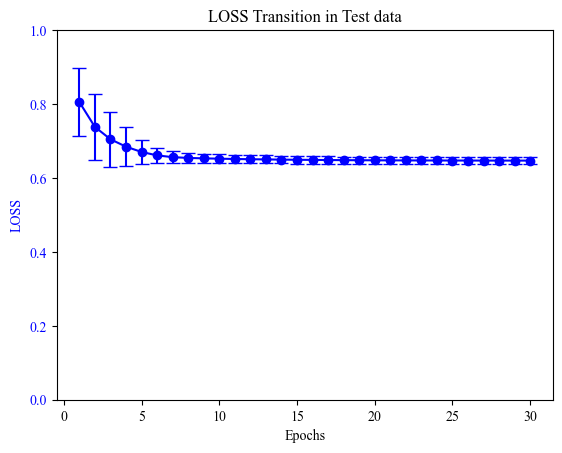

In [8]:
input_dim = X_scaled.shape[1]
max_epochs = 30 #30
lr = 1e-4 #学習率

num_try = 5 #5

leverages = [1,2,3,6]
results = []
All_last_LOSSs_ = []
All_last_ACCs_ = []
for leverage in leverages: 
    
    All_last_loss = []
    All_loss_test = []
    All_pro_time = []
    All_test_acc = []

    for num_times in range(num_try): 
        train_dataloader, test_dataloader, num_pos, num_neg = get_new_dataloader(X_scaled,y_origin)
        model = EncoderClassifier(input_dim,leverage).to(device)
        #pos_weight = torch.tensor([num_neg / num_pos], dtype=torch.float32).to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        loss_train_ = []
        loss_test_ = []
        pro_time_ = []

        for epoch in range(max_epochs):
            model.train()
            epoch_loss_train = 0
            sys.stderr.write('\r1:%d %dth Epoch: %d/%d' % (leverage,num_times+1, epoch, max_epochs))  
            sys.stderr.flush()

            start_time1 = time.time()
            for batch_X, batch_Y in train_dataloader:
                batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
                batch_Y = batch_Y.view(-1, 1)
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_Y)
                loss.backward()
                optimizer.step()

                epoch_loss_train += loss.item()

            epoch_loss_train /= len(train_dataloader)
            loss_train_.append(epoch_loss_train)
            end_time1 = time.time()
            pro_time_.append(end_time1-start_time1)

            # テスト損失計算
            model.eval()
            with torch.no_grad():
                all_preds = []
                all_labels = []
                correct = 0
                total = 0
                loss_test = 0.0
                first_batch = True

                for batch_x, batch_y in test_dataloader:
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                    batch_y = batch_y.view(-1, 1)
                    outputs = model(batch_x).to(device)  # 出力は sigmoid による確率

                    predicted = (outputs > 0.5).float()  # しきい値 0.5 による2値化
                    loss = criterion(outputs, batch_y)
                    loss_test += loss.item()

                    total += batch_y.size(0)
                    correct += (predicted == batch_y).sum().item()
                    all_preds.extend(predicted.cpu().numpy().astype(int))
                    all_labels.extend(batch_y.cpu().numpy().astype(int))


                    
                    if epoch == max_epochs - 1:
                        if first_batch:
                            x_encoded = model.encoder(batch_x)
                            x_in =  batch_x.detach().cpu().numpy()
                            print('IN',x_in[0])
                            print('OUT',x_encoded[0])
                            first_batch = False
            
            loss_test_avg = loss_test / len(test_dataloader)

            #loss_train_.append(loss_train_avg)
            loss_test_.append(loss_test_avg)
        All_loss_test.append(loss_test_)
        All_pro_time.append(sum(pro_time_)) 

        cm = confusion_matrix(all_labels, all_preds)
        cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # 正規化（行ごとに割合に）

        Last_loss_test = loss_test_[-1]
        All_last_loss.append(Last_loss_test)
        Test_acc = 100 * correct / total
        All_test_acc.append(Test_acc)

        class_names = ['Normal', 'Abnormal']
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names, vmin=0.0, vmax=1.0)
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.title(f"Overall Accuracy: {Test_acc:.2f}%")
        plt.show()

    All_last_LOSSs_.append(All_last_loss)
    All_last_ACCs_.append(All_test_acc)
    
    ACC_mean = np.mean(All_test_acc)
    ACC_best = np.max(All_test_acc)
    ACC_bestID = np.argmax(All_test_acc)+1
    ACC_worst = np.min(All_test_acc)
    ACC_worstID = np.argmin(All_test_acc)+1

    LOSS_mean = np.mean(All_last_loss)
    LOSS_best = np.min(All_last_loss)
    LOSS_bestID = np.argmin(All_last_loss)+1
    LOSS_worst = np.max(All_last_loss)
    LOSS_worstID = np.argmax(All_last_loss)+1

    data = {
            "": ["ACC", "LOSS"],
        "Average": [ACC_mean, LOSS_mean],
        "Best ID": [ACC_bestID, LOSS_bestID],
        "Best": [ACC_best, LOSS_best],
        "Worst ID": [ACC_worstID, LOSS_worstID],
        "Worst": [ACC_worst, LOSS_worst],
    }

    df = pd.DataFrame(data)
    results.append(data)
    print(df)
    epochs = len(All_loss_test[0])  # エポック数（各リストの長さ）
    num_dimensions = len(All_loss_test)  # 埋め込み次元数の数

    # 各エポックごとに平均と標準偏差を計算
    mean_loss = np.mean(All_loss_test, axis=0)
    std_loss = np.std(All_loss_test, axis=0)

    # グラフの描画
    fig, ax1 = plt.subplots()

    # 平均値の折れ線グラフと誤差範囲（標準偏差の誤差棒）
    ax1.errorbar(
        x=range(1, epochs + 1), y=mean_loss, yerr=std_loss,
        fmt='-o', color='blue', ecolor='blue', capsize=5, 
    )

    # 軸ラベルやタイトルの設定
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('LOSS', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    plt.title('LOSS Transition in Test data')
    plt.ylim(0,1.0)
    plt.show()


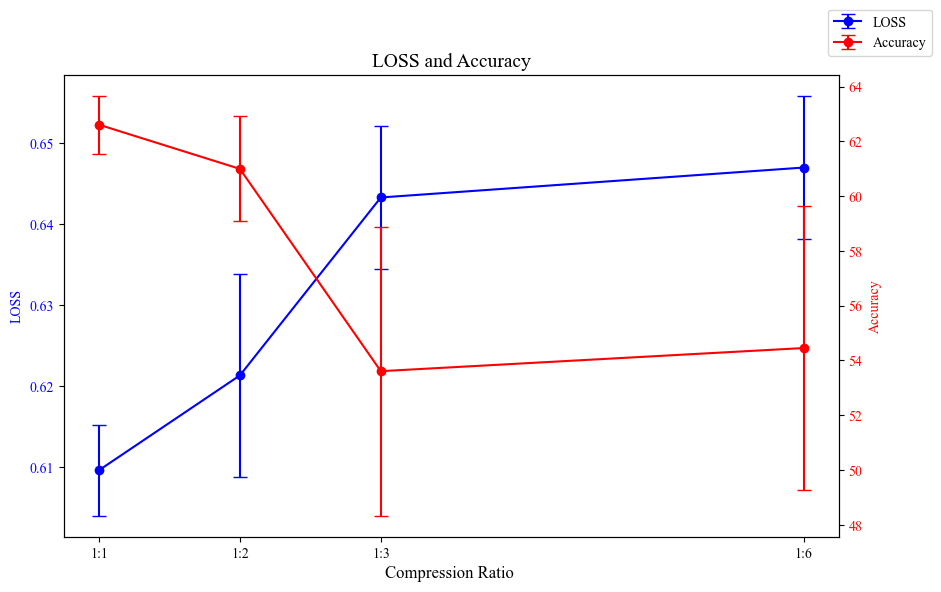

In [9]:
# 横軸の値 (1/leverage)
x_values = [leverage for leverage in leverages]
memory_lis =[1,2,3,6]

# LOSS用の平均値と標準偏差を計算
loss_means = [np.mean(loss_list) for loss_list in All_last_LOSSs_]
loss_stds = [np.std(loss_list) for loss_list in All_last_LOSSs_]

# ACC用の平均値と標準偏差を計算
acc_means = [np.mean(acc_list) for acc_list in All_last_ACCs_]
acc_stds = [np.std(acc_list) for acc_list in All_last_ACCs_]

# グラフの描画
fig, ax1 = plt.subplots(figsize=(10, 6))

# MSEのエラーバー付き折れ線グラフ
ax1.errorbar(
    x=x_values, y=loss_means, yerr=loss_stds,
    fmt='-o', color='blue', ecolor='blue', capsize=5, label='LOSS'
)
ax1.set_ylabel('LOSS', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
# SSIMのエラーバー付き折れ線グラフ
ax2.errorbar(
    x=x_values, y=acc_means, yerr=acc_stds,
    fmt='-o', color='red', ecolor='red', capsize=5, label='Accuracy'
)
ax2.set_ylabel('Accuracy', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 軸ラベルとスケールの設定
ax1.set_xlabel('Compression Ratio ', fontsize=12)

ax1.set_xticks(memory_lis)
ax1.set_xticklabels([f"1:{x}" for x in memory_lis]) # ラベルを「1:N」形式で表示

# タイトルと凡例
plt.title('LOSS and Accuracy', fontsize=14)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(
    lines1 + lines2, labels1 + labels2, loc="upper right", bbox_to_anchor=(1, 1)
)
plt.show()

In [10]:
all_data = pd.concat([pd.DataFrame(result) for result in results], ignore_index=True)
print(all_data)

           Average  Best ID       Best  Worst ID      Worst
0   ACC  62.605580        5  64.141285         1  61.351421
1  LOSS   0.609571        5   0.602764         2   0.617964
2   ACC  60.993089        4  62.810340         1  57.332992
3  LOSS   0.621296        4   0.599275         1   0.637711
4   ACC  53.606348        2  61.351421         4  46.711031
5  LOSS   0.643292        2   0.631235         5   0.656818
6   ACC  54.450985        5  59.815715         2  45.303302
7  LOSS   0.646991        5   0.629478         2   0.653852


In [11]:
import csv
save_directory1 = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoMotive_data_001','texts') 
print(save_directory1)
os.makedirs(save_directory1, exist_ok=True)
file_name = 'MLP_VCR_LI_Class00_list.csv'##
full_path = os.path.join(save_directory1, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(All_last_LOSSs_)
    writer.writerow(All_last_ACCs_)

C:\Users\Scent\OneDrive\CODES\konishi_AutoEncoder\AutoMotive_data_001\texts
